In [1]:
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=0)

In [2]:
SIZE = 100_000
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)

BASE_CHURN = 0.15 

ppl = pd.DataFrame(
    {
        # "bad_exp": rng.binomial(
        #    1, 0.1, SIZE
        # ),  # True if they had a bad experience with company
        "mkt_neg": rng.binomial(
            1, 0.1, SIZE
        ),  # True if receiving marketing will increase churn probability for them
    }
)
ppl["gets_mkting"] = rng.binomial(1, 0.5, SIZE)

ppl["prob_churn"] = BASE_CHURN  # a reasonably standard churn rate

In [3]:
# people who hate marketing and who get marketing have a higher chance of churning
mask = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1 # trues are 1s (ints)
ppl.loc[mask, "prob_churn"] += 0.25 # TODO HUGE BIAS
assert (
    mask.sum() / mask.shape[0] < 0.2
), "Not expecting a high rate of churn even with random variation"
ppl[mask].sample(5)

,mkt_neg,gets_mkting,prob_churn
68471,1,1,0.4
3933,1,1,0.4
64629,1,1,0.4
86380,1,1,0.4
90384,1,1,0.4


In [4]:
ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])

In [5]:
ppl.head()

,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,1,0.15,0
1,0,0,0.15,0
2,0,1,0.15,0
3,0,1,0.15,1
4,0,1,0.15,0


In [6]:
ppl.describe()

,mkt_neg,gets_mkting,prob_churn,will_churn
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.099050,0.497500,0.162175,0.162690
std,0.298731,0.499996,0.053810,0.369084
min,0.000000,0.000000,0.150000,0.000000
25%,0.000000,0.000000,0.150000,0.000000
50%,0.000000,0.000000,0.150000,0.000000
75%,0.000000,1.000000,0.150000,0.000000
max,1.000000,1.000000,0.400000,1.000000


In [7]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

schema = pa.DataFrameSchema(
    {
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "gets_mkting": pa.Column(int, pa.Check.isin([0, 1])),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        "prob_churn": pa.Column(float,    [pa.Check.le(1.0), pa.Check.ge(0), pa.Hypothesis.two_sample_ttest(
                sample1=1,
                sample2=0,
                groupby="mkt_neg",
                relationship="greater_than",
                alpha=0.05,
                equal_var=True)])
    }
)
schema.validate(ppl, lazy=True)

,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,1,0.15,0
1,0,0,0.15,0
2,0,1,0.15,0
3,0,1,0.15,1
4,0,1,0.15,0
...,...,...,...,...
99995,0,0,0.15,0
99996,0,0,0.15,0
99997,0,0,0.15,0
99998,0,1,0.15,0


# Look at some examples of those who do or don't churn

In [8]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN").iloc[[0]]

,mkt_neg,gets_mkting,prob_churn,will_churn
90,1,1,0.4,1


In [9]:
ppl.query("will_churn==True and prob_churn == @BASE_CHURN").iloc[[0]]

,mkt_neg,gets_mkting,prob_churn,will_churn
3,0,1,0.15,1


In [10]:
ppl.query("will_churn==False").iloc[[0]]

,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,1,0.15,0


# Start to prepare for ML

In [11]:
features = ['mkt_neg']
ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(ppl, ppl[features], ppl['will_churn'], test_size=0.3, shuffle=True)
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(70000, 4), (30000, 4), (70000, 1), (30000, 1), (70000,), (30000,)]


In [12]:
est_dummy = DummyClassifier(strategy='prior')
est_dummy.fit(X_train, y_train)

#y_true

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.44620157360105545

In [13]:
est = LogisticRegression()
est.fit(X_train, y_train)

y_pred = est.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

0.4410157552619178

## Start to prepare for dual fit

In [14]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
est_up_c = LogisticRegression()
est_up_t = LogisticRegression()

mask_train_c = ppl_train['gets_mkting'] == 0
mask_train_t = ppl_train['gets_mkting'] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

mask_test_c = ppl_test['gets_mkting'] == 0
mask_test_t = ppl_test['gets_mkting'] == 1
lr_up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
lr_up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]

print(log_loss(y_test[mask_test_c], lr_up_c_pred_proba_pos))
print(log_loss(y_test[mask_test_t], lr_up_t_pred_proba_pos)) # CHECK expect lower than control

0.42286118470659784
0.45089655726510136


# diagnostics might not be right yet!

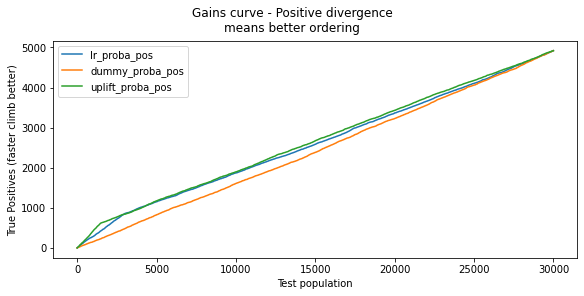

In [15]:
result = pd.DataFrame({'lr_proba_pos': y_pred_proba_pos, 'y_true': y_test})
result['dummy_proba_pos'] = est_dummy.predict_proba(X_test)[:, 1]

result['uplift_proba_pos'] = 0
result.loc[mask_test_t, 'uplift_proba_pos'] = lr_up_t_pred_proba_pos
result.loc[mask_test_c, 'uplift_proba_pos'] = lr_up_c_pred_proba_pos


fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
keys = ['lr_proba_pos', 'dummy_proba_pos', 'uplift_proba_pos']
for key in keys:
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted['y_true_cum'] = result_sorted['y_true'].cumsum()
    result_sorted.plot(kind='line', y='y_true_cum', ax=ax, label=key)
ax.set_ylabel('True Positives (faster climb better)');
ax.set_xlabel('Test population');